# <b>Projekt 2. - Wykrywanie naczyń dna siatkówki oka</b>
### <b>Autorzy:</b> Wiktoria Białasik 151436, Mateusz Czechowski 155921

## <u>Zastosowany język programowania oraz użyte biblioteki</u>
<p> W projekcie wykorzystano język programowania <b>Python</b> oraz posłużono się bibliotekami wymienionymi poniżej. 

In [108]:
import os
import ipywidgets as widgets
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import frangi
from IPython.display import display, clear_output
from skimage.exposure import rescale_intensity
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import gmean
from sklearn.metrics import classification_report
import seaborn as sns
from skimage.filters import threshold_otsu
import skimage.filters as fil
from skimage.exposure import rescale_intensity, adjust_gamma
from skimage.measure import moments_central, moments_hu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Odczyt oraz wyświetlenie obrazu wejściwego - zdjęcia siatkówki oka

Dropdown(description='Pick image', index=1, options=('10_bad.JPG', '10_good.JPG', '11_bad.JPG', '11_good.JPG',…

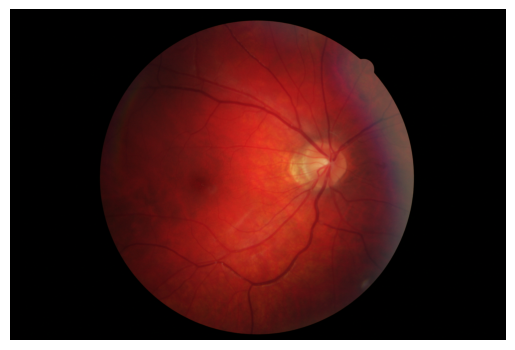

In [2]:
image = None
filename = ''
dir = './input-data/'
examples_list = [file for file in os.listdir(dir) ]

filename_picker = widgets.Dropdown(
    options=examples_list,
    description="Pick image",
    disabled=False
)

def show(change):
    global image, filename, image_color
    clear_output(wait=True)
    display(filename_picker)
    selected_file = change['new']
    
    if selected_file:
        file_path = os.path.join(dir, selected_file)
    
        image = mpimg.imread(file_path)
        if len(image.shape) == 3:
            plt.imshow(image) 
            plt.axis('off')
            plt.show()
            image_color = (image * 255).astype(np.uint8)
            image = np.mean(image, axis=2)

        filename = os.path.splitext(filename_picker.value)[0]
        print(filename)

filename_picker.observe(show, names='value')
display(filename_picker)


### Wstępne przetwarzanie obrazu

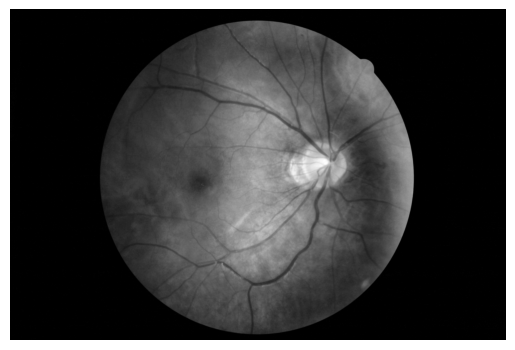

In [95]:
def preprocess_image(image):
    if len(image.shape) == 3:
        green_channel = image[:, :, 1] 
    else:
        green_channel = image

    green_channel = green_channel.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_eq = clahe.apply(green_channel)
    median = cv2.medianBlur(image_eq, 5)
    blurred = cv2.GaussianBlur(median, (5, 5), 0)
    final = rescale_intensity(blurred, in_range='image', out_range=(0, 255))

    #fill = fil.sato(blurred, mode='constant')

    return blurred

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

blured_image = preprocess_image(image)
show_image(blured_image) 


### Właściwe przetwarzanie obrazu - Filtr Frangiego

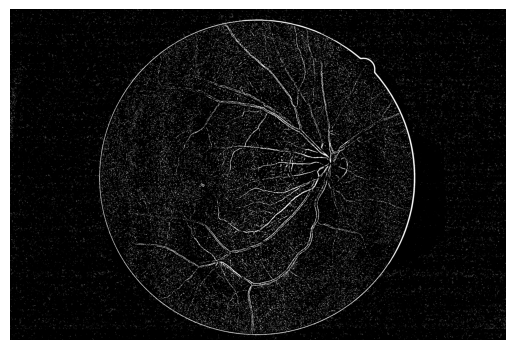

In [96]:
def frangi_filter(image, precentile=95):
    image = image.astype(np.float64) / 255.0
    frangi_result = frangi(image, sigmas=(1, 6), scale_step=2)

    threshold = np.percentile(frangi_result, precentile) 
    binary_mask = (frangi_result > threshold).astype(np.uint8)

    return binary_mask

vessel_mask = frangi_filter(blured_image)
show_image(vessel_mask)


### Końcowe przetwarzanie - oczyszczanie maski

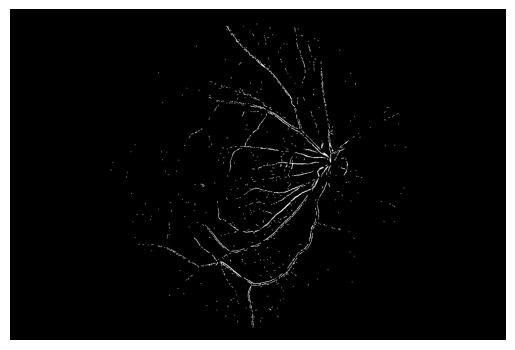

In [104]:
def postprocess_mask(mask):
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    return cleaned

def remove_eye_border(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return mask  
    
    max_contour = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(max_contour)
    center = (int(x), int(y))
    radius = int(radius * 0.95)  
    
    mask_circle = np.zeros_like(mask)
    cv2.circle(mask_circle, center, radius, 1, thickness=-1)

    return mask * mask_circle

def remove_small_objects(mask, min_size=100):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned_mask = np.zeros_like(mask)

    for i in range(1, num_labels):  
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            cleaned_mask[labels == i] = 1
    return cleaned_mask

postprocessed_mask = postprocess_mask(vessel_mask)
postprocessed_mask = remove_small_objects(postprocessed_mask, min_size=25)
postprocessed_mask = remove_eye_border(postprocessed_mask)
show_image(postprocessed_mask)

### Nakłądanie konturów na oryginalny obraz

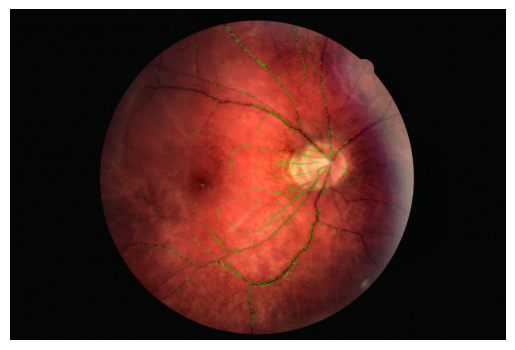

True

In [105]:
def visualize_mask(original, mask, color=(0, 255, 0), alpha=0.7, enhance_contrast=True):
    if enhance_contrast:
        lab = cv2.cvtColor(original, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        original = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    overlay = original.copy()
    overlay[mask == 1] = color
    return cv2.addWeighted(original, 1 - alpha, overlay, alpha, 0)

file_path = os.path.join(dir, filename + '.jpg')

img = cv2.imread(file_path)
vis = visualize_mask(img, postprocessed_mask, color=(0, 255, 0), alpha=0.7)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

output_folder = 'output-data'
os.makedirs(output_folder, exist_ok=True)

output_path = os.path.join(output_folder, 'vessels_overlay.png')
cv2.imwrite(output_path, vis)

Metryki...........

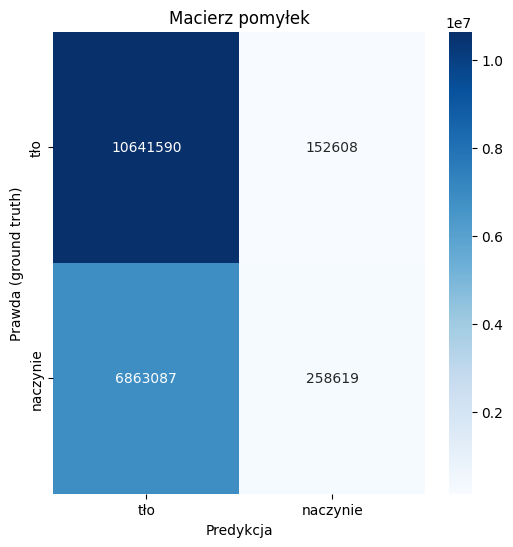

              precision    recall  f1-score   support

         tło       0.61      0.99      0.75  10794198
    naczynie       0.63      0.04      0.07   7121706

    accuracy                           0.61  17915904
   macro avg       0.62      0.51      0.41  17915904
weighted avg       0.62      0.61      0.48  17915904



In [38]:
if image.dtype == np.float32 or image.dtype == np.float64:
    img_uint8 = (image * 255).astype(np.uint8)
else:
    img_uint8 = image

if len(img_uint8.shape) == 3:
    gray_mask = np.mean(img_uint8, axis=2).astype(np.uint8)
else:
    gray_mask = img_uint8.astype(np.uint8)

expert_mask_bin = (gray_mask > 127).astype(np.uint8)

y_true = expert_mask_bin.flatten()
y_pred = postprocessed_mask.flatten()

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['tło', 'naczynie'], yticklabels=['tło', 'naczynie'])
plt.xlabel('Predykcja')
plt.ylabel('Prawda (ground truth)')
plt.title('Macierz pomyłek')
plt.show()

print(classification_report(y_true, y_pred, target_names=['tło', 'naczynie']))

### Wersja 4.0

In [110]:
def extract_features_and_labels(image, expert_mask, patch_size=5, max_samples=5000):
    pad = patch_size // 2
    padded_img = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    padded_mask = cv2.copyMakeBorder(expert_mask, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    X, y = [], []
    for i in range(pad, padded_img.shape[0] - pad):
        for j in range(pad, padded_img.shape[1] - pad):
            patch = padded_img[i-pad:i+pad+1, j-pad:j+pad+1]
            label = padded_mask[i, j]
            var = np.var(patch)
            mu = moments_central(patch)
            hu = moments_hu(mu)
            X.append([var] + list(hu))
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    
    # Undersampling dla zrównoważenia klas
    from imblearn.under_sampling import RandomUnderSampler
    rus = RandomUnderSampler()
    X_res, y_res = rus.fit_resample(X, y)

    # Ograniczenie liczby próbek (opcjonalne)
    if len(y_res) > max_samples:
        idx = np.random.choice(len(y_res), max_samples, replace=False)
        X_res, y_res = X_res[idx], y_res[idx]

    return X_res, y_res

gray_img = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image
expert_mask_bin = (gray_img > 127).astype(np.uint8)

X, y = extract_features_and_labels(gray_img, expert_mask_bin)


In [111]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['tło', 'naczynie']))


              precision    recall  f1-score   support

         tło       1.00      1.00      1.00       512
    naczynie       1.00      1.00      1.00       488

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [112]:
def classify_image(image, clf, patch_size=5):
    pad = patch_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    result = np.zeros(image.shape, dtype=np.uint8)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            patch = padded[i:i+patch_size, j:j+patch_size]
            var = np.var(patch)
            mu = moments_central(patch)
            hu = moments_hu(mu)
            features = np.array([var] + list(hu)).reshape(1, -1)
            result[i, j] = clf.predict(features)[0]
    return result

prediction_mask = classify_image(gray_img, clf)


c:\Users\Mateusz\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\_moments_analytical.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cx = m[1, 0] / m[0, 0]
c:\Users\Mateusz\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\_moments_analytical.py:42: RuntimeWarning: invalid value encountered in scalar divide
  cy = m[0, 1] / m[0, 0]
c:\Users\Mateusz\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\_moments_analytical.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cx = m[1, 0] / m[0, 0]
c:\Users\Mateusz\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\_moments_analytical.py:42: RuntimeWarning: invalid value encountered in scalar divide
  cy = m[0, 1] / m[0, 0]
c:\Users\Mateusz\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\_moments_analytical.py:41: RuntimeWarning: invalid value encountered in scalar divide
  cx = m[1, 0] 

KeyboardInterrupt: 

In [ ]:
def visualize_mask(original, mask, color=(0, 255, 0), alpha=0.7):
    overlay = original.copy()
    overlay[mask == 1] = color
    return cv2.addWeighted(original, 1 - alpha, overlay, alpha, 0)

img_color = cv2.imread(os.path.join(dir, filename + '.jpg'))
vis = visualize_mask(img_color, prediction_mask)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Wizualizacja klasyfikatora")
plt.show()

cm = confusion_matrix(expert_mask_bin.flatten(), prediction_mask.flatten())
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['tło', 'naczynie'], yticklabels=['tło', 'naczynie'])
plt.xlabel('Predykcja')
plt.ylabel('Prawda (ground truth)')
plt.title('Macierz pomyłek klasyfikatora')
plt.show()

print(classification_report(expert_mask_bin.flatten(), prediction_mask.flatten(), target_names=['tło', 'naczynie']))
